In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model, metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE

from sklearn.model_selection import train_test_split


from scipy.stats import boxcox

import os

pd.set_option('display.max_columns', None)
# hide warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
def replace_low_freq(df, threshold=100, replacement='other'):
    s = df.stack()
    c = s.value_counts()
    m = pd.Series(replacement, c.index[c <= threshold])
    return s.replace(m).unstack()

In [3]:
def findSkewedColumns(columns, df, thresholdPercent = 80, displayValueCounts = False):
    skewedColumns = []
    for col in columns:
        valueCounts = (100*df[col].value_counts(normalize=True)).to_dict()
        if(displayValueCounts):
            print(col)
            print(valueCounts)
        abovethreshold = list(filter(lambda x:x>thresholdPercent, valueCounts.values()))
        if(len(abovethreshold)>0):
            skewedColumns.append(col)
    return skewedColumns

In [4]:
pricingInfo = pd.read_csv('train.csv')
pricingInfo.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,NaN,Attchd,1993.0,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.0,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.0,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.0,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.0,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.0,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.0,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,Artery,2fmCon,1.5Unf,5,6,1939,1950,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,BrkTil,TA,TA,No,GLQ,851,Unf,0,140,991,Gas

In [5]:
pricingInfo.shape

(1460, 81)

In [6]:
pricingInfo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

### Inspecting and handling null values

In [7]:
# inspect null values
nulls = round(100*(pricingInfo.isnull().sum()/len(pricingInfo.index)), 2).sort_values(ascending=False)
nulls = nulls[nulls.values>0]
nulls

PoolQC          99.52
MiscFeature     96.30
Alley           93.77
Fence           80.75
FireplaceQu     47.26
LotFrontage     17.74
GarageCond       5.55
GarageType       5.55
GarageYrBlt      5.55
GarageFinish     5.55
GarageQual       5.55
BsmtExposure     2.60
BsmtFinType2     2.60
BsmtFinType1     2.53
BsmtCond         2.53
BsmtQual         2.53
MasVnrArea       0.55
MasVnrType       0.55
Electrical       0.07
dtype: float64

In [8]:
# droping columns with >80% of null values and id column
pricingInfo.drop(['Id','PoolQC', 'Alley', 'Fence', 'MiscFeature'], axis=1, inplace=True)

#### investigate FireplaceQu

In [9]:
pricingInfo.FireplaceQu.value_counts(normalize=True, dropna=False) 

NaN    0.472603
Gd     0.260274
TA     0.214384
Fa     0.022603
Ex     0.016438
Po     0.013699
Name: FireplaceQu, dtype: float64

In [10]:
pricingInfo.FireplaceQu.fillna('NoFirePlace', inplace=True)

In [11]:
pricingInfo.FireplaceQu.value_counts(normalize=True, dropna=False) 

NoFirePlace    0.472603
Gd             0.260274
TA             0.214384
Fa             0.022603
Ex             0.016438
Po             0.013699
Name: FireplaceQu, dtype: float64

#### investigate BsmtCond

In [12]:
pricingInfo.BsmtCond.value_counts(normalize=True, dropna=False) 

TA     0.897945
Gd     0.044521
Fa     0.030822
NaN    0.025342
Po     0.001370
Name: BsmtCond, dtype: float64

In [13]:
pricingInfo.BsmtCond.fillna('NoBasement', inplace=True)

In [14]:
pricingInfo.BsmtCond.value_counts(normalize=True, dropna=False) 

TA            0.897945
Gd            0.044521
Fa            0.030822
NoBasement    0.025342
Po            0.001370
Name: BsmtCond, dtype: float64

In [15]:
#garage type
pricingInfo.GarageType.fillna('NoGarage', inplace=True)

In [16]:
#garage condition
pricingInfo.GarageCond.fillna('NoGarage', inplace=True)

In [17]:
#garage condition
pricingInfo.GarageFinish.fillna('NoGarage', inplace=True)

In [18]:
#garage condition
pricingInfo.GarageQual.fillna('NoGarage', inplace=True)

In [19]:
#basement condition
pricingInfo.BsmtFinType1.fillna('NoBasement', inplace=True)

In [20]:
#basement condition
pricingInfo.BsmtFinType2.fillna('NoBasement', inplace=True)

In [21]:
#basement condition
pricingInfo.BsmtQual.fillna('NoBasement', inplace=True)

In [22]:
#basement condition
pricingInfo.BsmtExposure.fillna('NoBasement', inplace=True)

In [23]:
pricingInfo.MasVnrType.value_counts(dropna=False)

None       864
BrkFace    445
Stone      128
BrkCmn      15
NaN          8
Name: MasVnrType, dtype: int64

In [24]:
## investigate relation between nulls of masvnrType and masvnrares
pricingInfo.loc[((pricingInfo.MasVnrType.isnull()) & (pricingInfo.MasVnrArea.notna()))]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice


#### Observation
MasVnrArea is null only if MasVnrType is null. which means whem MasVnrArea is not available. hence area can be set to 0.

In [25]:
#masvnrtyp condition
pricingInfo.MasVnrType.fillna(pricingInfo.MasVnrType.mode()[0], inplace=True)
pricingInfo.MasVnrArea.fillna(0, inplace=True)

In [26]:
nulls = round(100*(pricingInfo.isnull().sum()/len(pricingInfo.index)), 2).sort_values(ascending=False)
nulls = nulls[nulls.values>0]
nulls

LotFrontage    17.74
GarageYrBlt     5.55
Electrical      0.07
dtype: float64

In [27]:
pricingInfo.GarageYrBlt.describe()

count    1379.000000
mean     1978.506164
std        24.689725
min      1900.000000
25%      1961.000000
50%      1980.000000
75%      2002.000000
max      2010.000000
Name: GarageYrBlt, dtype: float64

In [28]:
# garage can either be build during initial construction or during remodaling. We are making an assumption here. 
# pricingInfo.loc[pricingInfo.GarageYrBlt.isnull(), 'GarageYrBlt'] = pricingInfo['YearRemodAdd']

In [29]:
pricingInfo.Electrical.value_counts(dropna=False)

SBrkr    1334
FuseA      94
FuseF      27
FuseP       3
Mix         1
NaN         1
Name: Electrical, dtype: int64

#### Observation
1 missing value. Hence can be dropped. 

In [30]:
print(pricingInfo.shape)
pricingInfo = pricingInfo[pricingInfo.Electrical.notna()]
print(pricingInfo.shape)

(1460, 76)
(1459, 76)


In [31]:
#LotFrontage    
pricingInfo.LotFrontage.describe(percentiles=[.1,.25,.3, .5,.75, .8,.9,.95,.97, .98 ,1])

count    1200.000000
mean       70.047500
std        24.294727
min        21.000000
10%        43.900000
25%        59.000000
30%        60.000000
50%        69.000000
75%        80.000000
80%        85.000000
90%        96.000000
95%       107.000000
97%       120.000000
98%       124.080000
100%      313.000000
max       313.000000
Name: LotFrontage, dtype: float64

#### Observation
Mean and meadian are approximately same hence any one can be used to impute. We are using mean as of now

In [32]:
pricingInfo.LotFrontage.fillna(pricingInfo.LotFrontage.mean(), inplace=True)

In [33]:
#investigate nulls again
nulls = round(100*(pricingInfo.isnull().sum()/len(pricingInfo.index)), 2).sort_values(ascending=False)
nulls = nulls[nulls.values>0]
nulls

GarageYrBlt    5.55
dtype: float64

### Creating derived variables from year variables

In [34]:
import datetime
def convertToAge(value , columnName):
    now = datetime.datetime.now()
    year = now.year
    if np.isnan(value):
        return -1
    else:
        return year - round(value)


In [35]:
# 1. YearBuilt
pricingInfo['PropertyAge'] = pricingInfo.YearBuilt.apply(convertToAge, args=['YearBuilt'])
pricingInfo.loc[:, ['PropertyAge', 'YearBuilt']].head()

,PropertyAge,YearBuilt
0,17,2003
1,44,1976
2,19,2001
3,105,1915
4,20,2000


In [36]:
# 2. YearRemodAdd
pricingInfo['YearsRemodel'] = pricingInfo.YearRemodAdd.apply(convertToAge, args=['YearRemodAdd'])
pricingInfo.loc[:, ['YearsRemodel', 'YearRemodAdd']].head()

,YearsRemodel,YearRemodAdd
0,17,2003
1,44,1976
2,18,2002
3,50,1970
4,20,2000


In [37]:
# 3.Yr Sold
pricingInfo['YearsSinceLastSold'] = pricingInfo.YrSold.apply(convertToAge, args=['YrSold'])
pricingInfo.loc[:, ['YearsSinceLastSold', 'YrSold']].head()

,YearsSinceLastSold,YrSold
0,12,2008
1,13,2007
2,12,2008
3,14,2006
4,12,2008


In [38]:
# 4. GarageYrBlt
pricingInfo['YearsSinceGarage'] = pricingInfo.GarageYrBlt.apply(convertToAge, args=['GarageYrBlt'])
pricingInfo.loc[:, ['YearsSinceGarage', 'GarageYrBlt']].head()

,YearsSinceGarage,GarageYrBlt
0,17,2003.0
1,44,1976.0
2,19,2001.0
3,22,1998.0
4,20,2000.0


## Exploratory data analysis

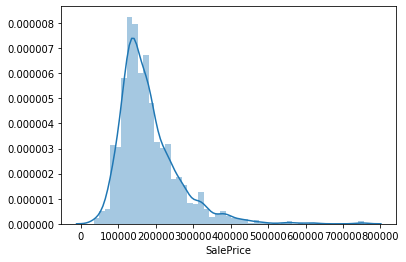

In [39]:
sns.distplot(pricingInfo.SalePrice)

#### Observation
We see that the distribution has outliers and is skewed. We will try to convert this to gausian form

In [40]:
pricingInfo[pricingInfo.SalePrice<=0]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,PropertyAge,YearsRemodel,YearsSinceLastSold,YearsSinceGarage


In [41]:
from numpy import exp

# power transform - logarithmic transformation
data = boxcox(pricingInfo.SalePrice, 0)
pricingInfo.SalePrice = data

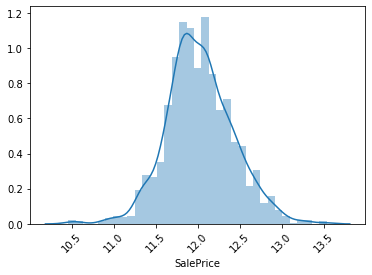

In [42]:
plt.xticks(rotation=45)
sns.distplot(pricingInfo.SalePrice)

### Observation
Log transformation converts the target variable to normal form. 

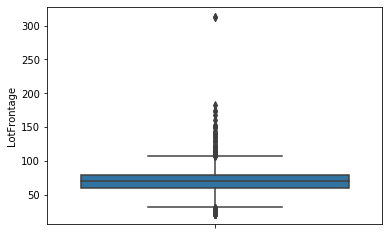

In [43]:
sns.boxplot(x='LotFrontage', data=pricingInfo, orient='v' )

#### Observation
Contains some outliers. Need to be handled.

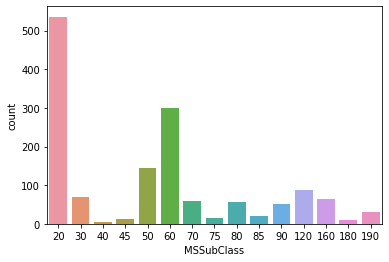

In [44]:
#Type of dwellings in sale
sns.countplot(pricingInfo.MSSubClass)

#### Observation. 
Most of the houses for sale are 1 storey wtih 1946 or above model or 2 story wtih 1946 or above model

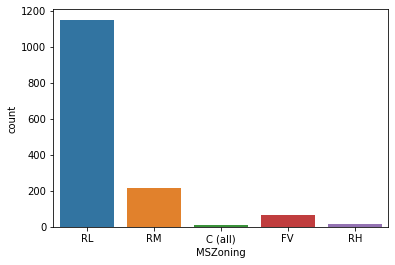

In [45]:
#Areas with number of properties for sale. 
sns.countplot(pricingInfo.MSZoning)

#### Observation
Most of the properties up for sale are in residentaiol areas with low density

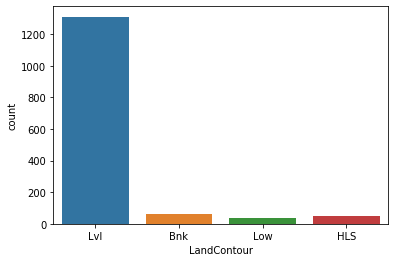

In [46]:
# number of properties for sale based on land conditions
sns.countplot(pricingInfo.LandContour)

In [47]:
pricingInfo.LandContour.value_counts(normalize=True)

Lvl    0.897875
Bnk    0.043180
HLS    0.034270
Low    0.024674
Name: LandContour, dtype: float64

#### Observation
Approx 90% of the values in given data are in level fields. This column is highly skewed.

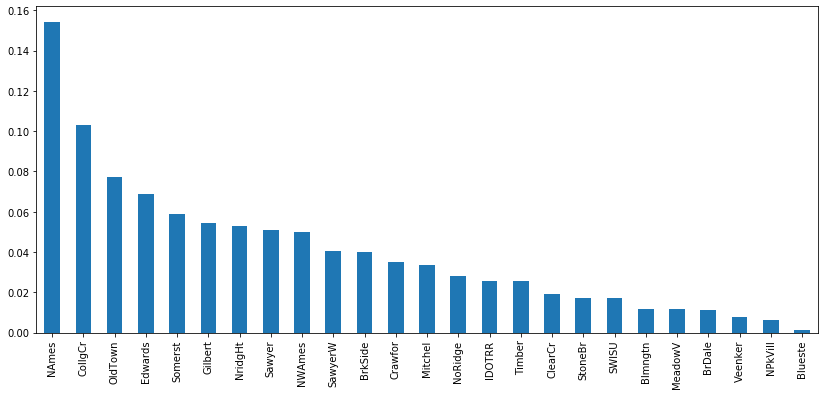

In [48]:
plt.figure(figsize=(14,6))
pricingInfo.Neighborhood.value_counts(normalize=True).plot.bar()

### Observation
North Ames has the highest number of properties up for sale followed by College creek

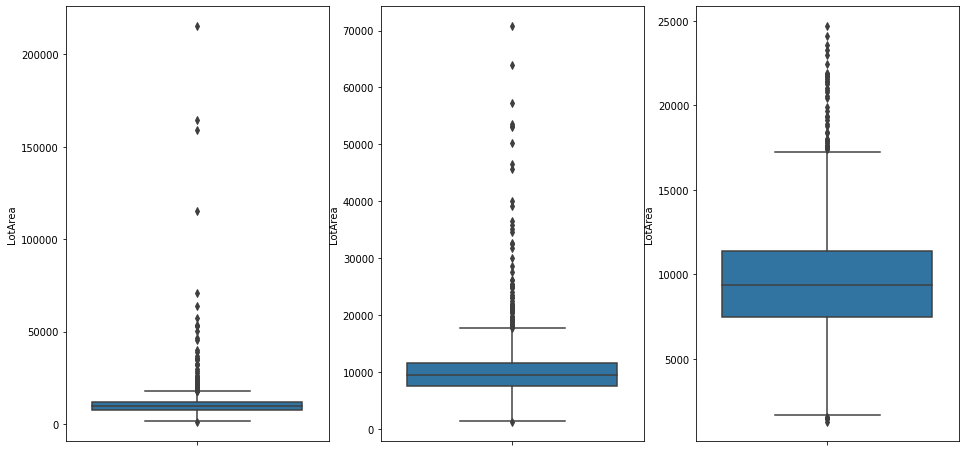

In [49]:
#Lot area distribution
plt.figure(figsize=(16,8))
plt.subplot(1, 3,1)
sns.boxplot(x='LotArea', data=pricingInfo, orient='v')

plt.subplot(1, 3,2)
sns.boxplot(x='LotArea', data=pricingInfo.loc[pricingInfo.LotArea<100000], orient='v')

plt.subplot(1, 3, 3)
sns.boxplot(x='LotArea', data=pricingInfo.loc[pricingInfo.LotArea<25000], orient='v')

In [50]:
pricingInfo.LotArea.describe(percentiles=[.1,.25,.3, .5,.75, .8,.9,.95,.97, .98 ,1])

count      1459.000000
mean      10517.363948
std        9984.666267
min        1300.000000
10%        5000.000000
25%        7549.000000
30%        8063.400000
50%        9477.000000
75%       11603.000000
80%       12206.600000
90%       14388.400000
95%       17402.300000
97%       21576.600000
98%       25255.440000
100%     215245.000000
max      215245.000000
Name: LotArea, dtype: float64

#### Observation - 
95% of the properties have lot area less than 20000. We can consider this column for capping

In [51]:
pricingInfo.loc[pricingInfo.LotArea>25251,['LotArea']].sort_values(by='LotArea')[:1]

,LotArea
876,25286


In [52]:
pricingInfo.loc[pricingInfo.LotArea>25251,'LotArea'] = 25286  

Text(0, 0.5, 'Percentage')

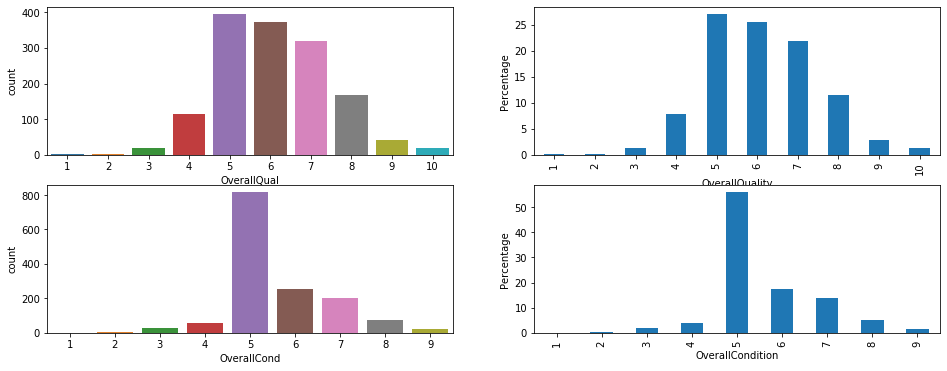

In [53]:
#Quality and condition of available properties
plt.figure(figsize=(16,6))
plt.subplot(2, 2,1)
sns.countplot(pricingInfo.OverallQual)

plt.subplot(2, 2,2)
(100*pricingInfo.OverallQual.value_counts(normalize=True, sort=False)).plot.bar()
plt.xlabel('OverallQuality')
plt.ylabel('Percentage')

plt.subplot(2, 2,3)
sns.countplot(pricingInfo.OverallCond)


plt.subplot(2, 2, 4)
(100*pricingInfo.OverallCond.value_counts(normalize=True, sort=False)).plot.bar()
plt.xlabel('OverallCondition')
plt.ylabel('Percentage')

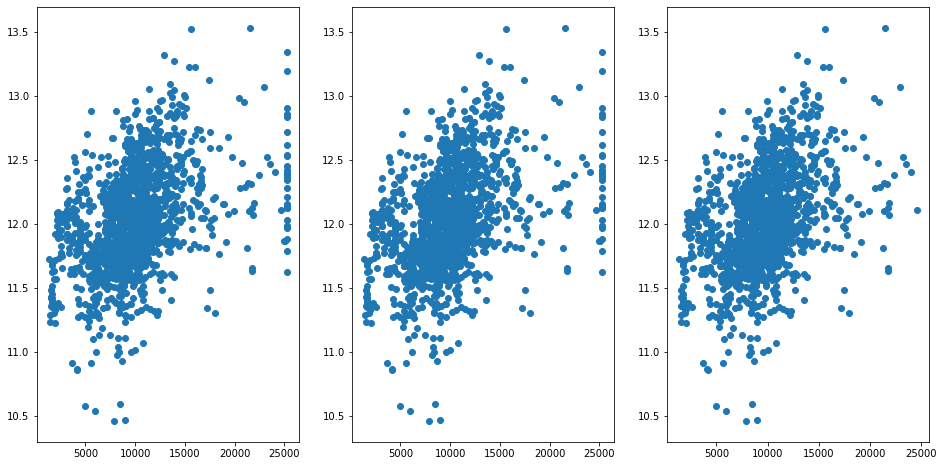

In [54]:
# area vs price
#Lot area distribution
plt.figure(figsize=(16,8))
plt.subplot(1, 3,1)
plt.scatter(x='LotArea', y='SalePrice', data=pricingInfo)

plt.subplot(1, 3,2)
plt.scatter(x='LotArea', y='SalePrice', data=pricingInfo.loc[pricingInfo.LotArea<40000])

plt.subplot(1, 3, 3)
plt.scatter(x='LotArea', y='SalePrice', data=pricingInfo.loc[pricingInfo.LotArea<25000])

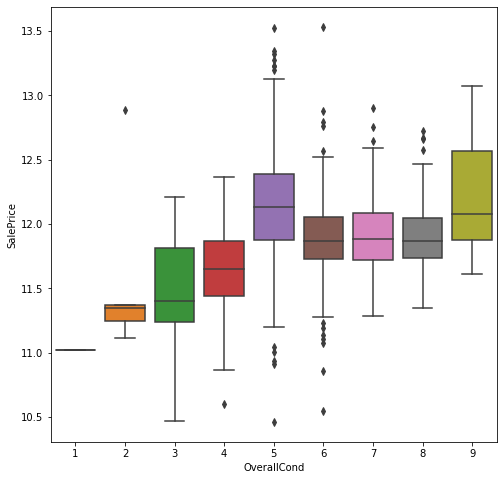

In [55]:
#OVerall condition vs pricing distribution
plt.figure(figsize=(8,8))
sns.boxplot(x='OverallCond',y='SalePrice',data=pricingInfo, orient='v')

#### Observation
median values of properties rated 5 and 9 are almost same. The properties rated 6, 7, 8 have lower median and high values. This column might not have much impact

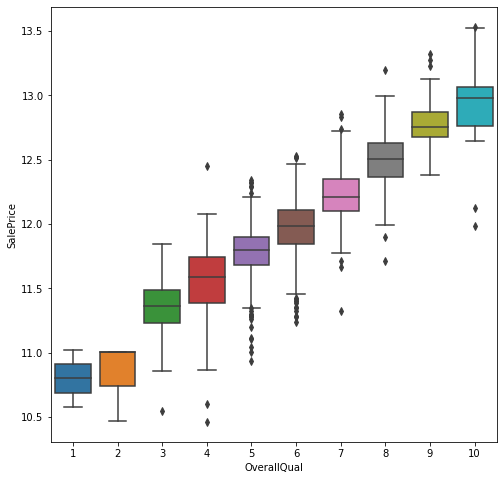

In [56]:
plt.figure(figsize=(8,8))
sns.boxplot(x='OverallQual',y='SalePrice',data=pricingInfo, orient='v')

#### Observation
We see the pricing of the properties keep increasing in a consistent manner as the overall quality of the property improves. Direct impact is evident

In [57]:
pricingInfo.YearBuilt.describe()

count    1459.000000
mean     1971.244003
std        30.199555
min      1872.000000
25%      1954.000000
50%      1973.000000
75%      2000.000000
max      2010.000000
Name: YearBuilt, dtype: float64

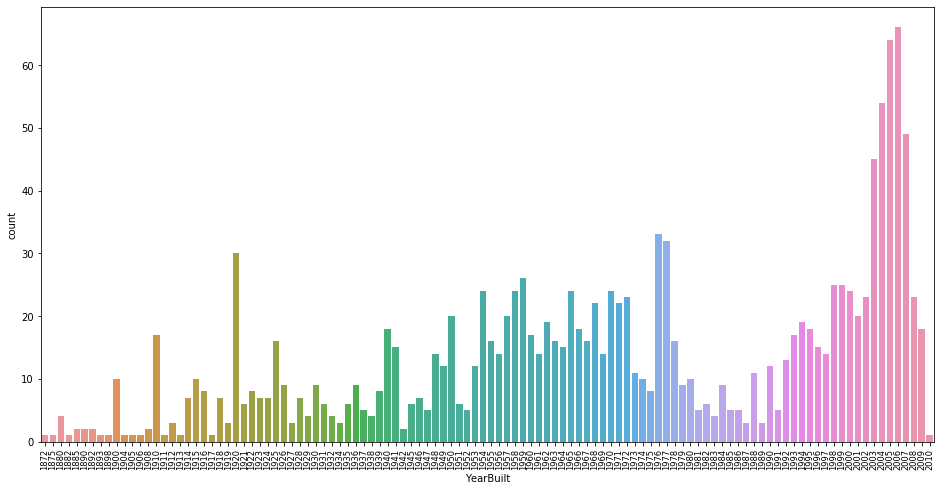

In [58]:
# number of properties by year
plt.figure(figsize=(16,8))
plt.xticks(rotation=90,fontweight='light',fontsize='small')
sns.countplot(pricingInfo.YearBuilt)

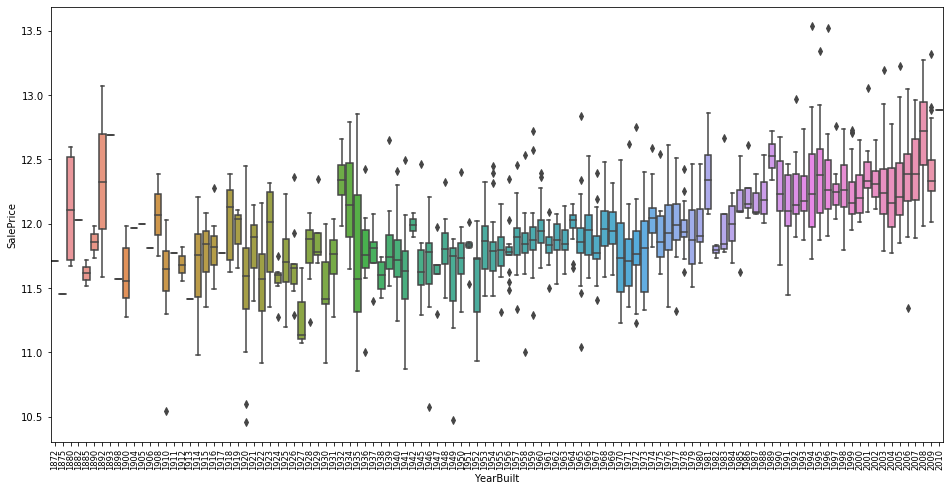

In [59]:
# number of properties by year
plt.figure(figsize=(16,8))
plt.xticks(rotation=90,fontweight='light',fontsize='small')
sns.boxplot(x='YearBuilt',y='SalePrice',data=pricingInfo, orient='v')

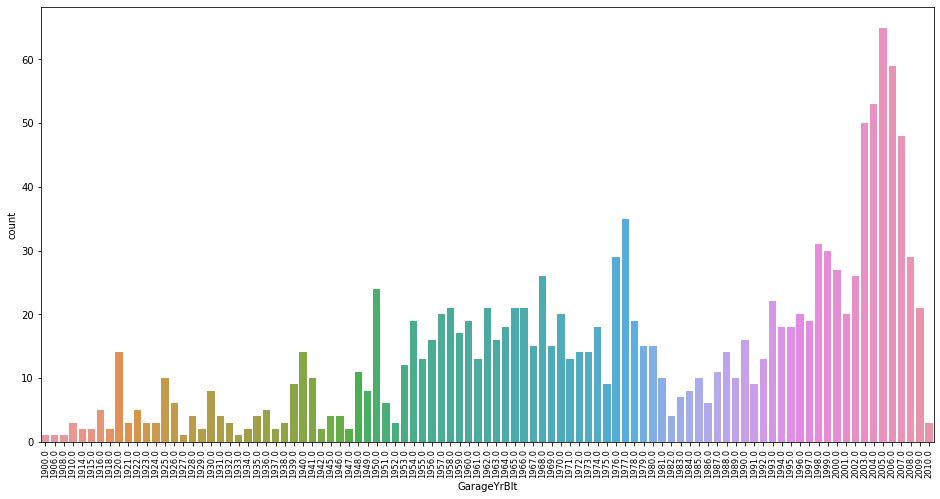

In [60]:
# number of properties by year
plt.figure(figsize=(16,8))
plt.xticks(rotation=90,fontweight='light',fontsize='small')
sns.countplot(pricingInfo.GarageYrBlt)

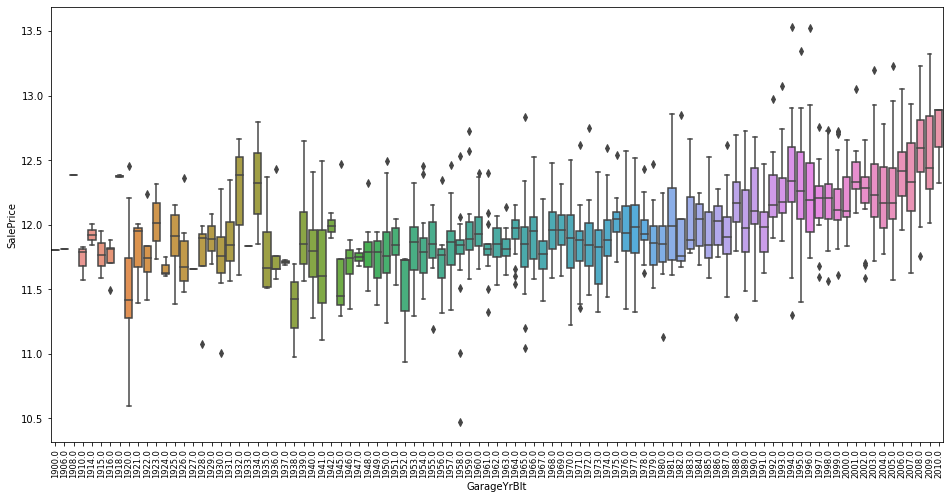

In [61]:
# number of properties by year
plt.figure(figsize=(16,8))
plt.xticks(rotation=90,fontweight='light',fontsize='small')
sns.boxplot(x='GarageYrBlt',y='SalePrice',data=pricingInfo, orient='v')

#### Observation
no direct relation between year of garage and price. hence dropping the column

In [62]:
pricingInfo.drop('GarageYrBlt', axis=1, inplace=True)

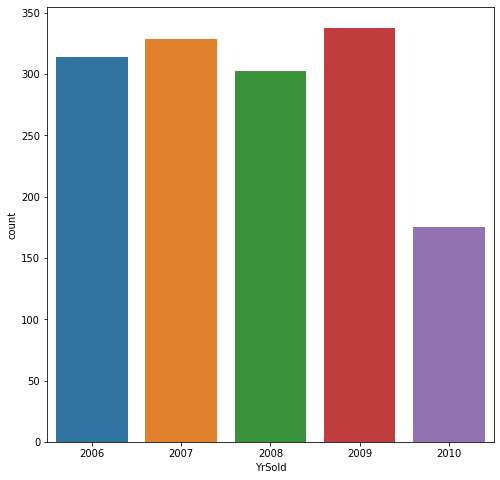

In [63]:
# properties sold by year
plt.figure(figsize=(8,8))
sns.countplot(x='YrSold', data=pricingInfo)

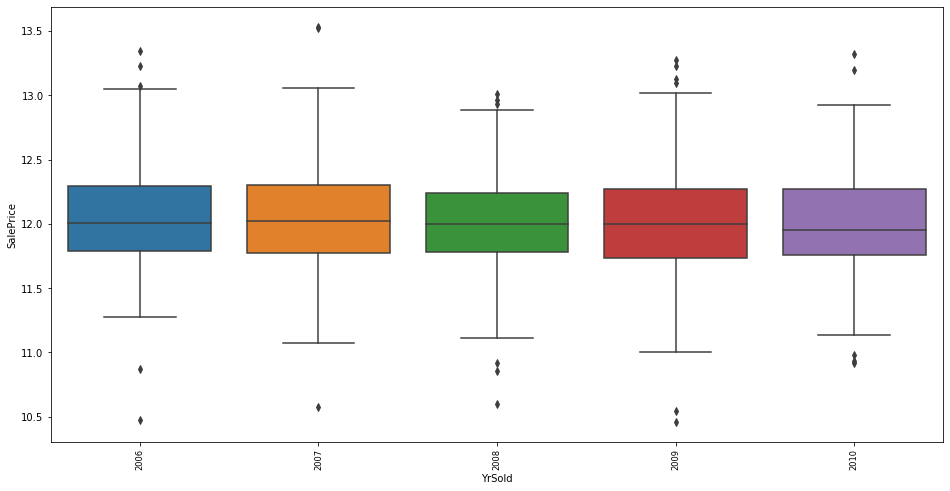

In [64]:
# year sold vs price
plt.figure(figsize=(16,8))
plt.xticks(rotation=90,fontweight='light',fontsize='small')
sns.boxplot(x='YrSold',y='SalePrice',data=pricingInfo, orient='v')

#### Observation
Market has been stable through years.
- Sales have been consitent
- Price ranges have also been in similar range with slight difference. 
- Since this is not impacting sales we may drop this column

In [65]:
pricingInfo.drop('YrSold', axis=1, inplace=True)

In [66]:
# inspect MasVnrArea
pricingInfo.MasVnrArea.describe(percentiles=[.1,.25,.3, .5,.75, .8,.9,.95,.97, .98,.99 ,1])

count    1459.000000
mean      103.187800
std       180.773158
min         0.000000
10%         0.000000
25%         0.000000
30%         0.000000
50%         0.000000
75%       164.500000
80%       205.400000
90%       335.000000
95%       456.000000
97%       573.780000
98%       650.840000
99%       791.360000
100%     1600.000000
max      1600.000000
Name: MasVnrArea, dtype: float64

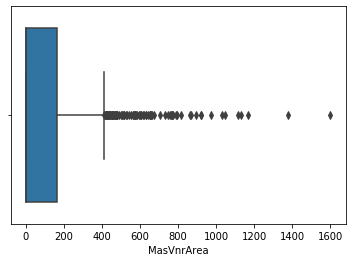

In [67]:
sns.boxplot(x='MasVnrArea', data=pricingInfo)

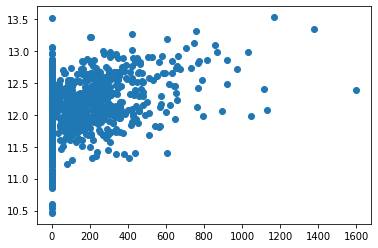

In [68]:
plt.scatter(x='MasVnrArea', y='SalePrice', data=pricingInfo)

#### Observation
Masonry veneer area does not seem to impact pricing. 

In [69]:
## caping this variable value so that outliers don't dicate result
pricingInfo.loc[pricingInfo.MasVnrArea>800,'MasVnrArea'] = 800

In [70]:
pricingInfo.MasVnrArea.describe(percentiles=[.1,.25,.3, .5,.75, .8,.9,.95,.97, .98,.99 ,1])

count    1459.000000
mean      100.769705
std       168.121401
min         0.000000
10%         0.000000
25%         0.000000
30%         0.000000
50%         0.000000
75%       164.500000
80%       205.400000
90%       335.000000
95%       456.000000
97%       573.780000
98%       650.840000
99%       791.360000
100%      800.000000
max       800.000000
Name: MasVnrArea, dtype: float64

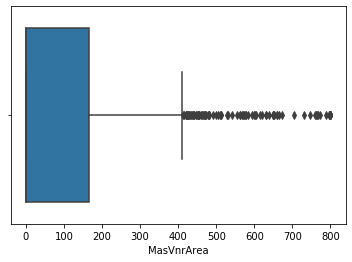

In [71]:
sns.boxplot(x='MasVnrArea', data=pricingInfo)

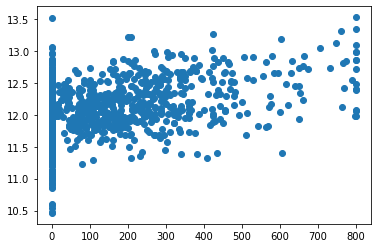

In [72]:
plt.scatter(x='MasVnrArea', y='SalePrice', data=pricingInfo)

### Dropping skewed columns

In [73]:
pricingInfo.SaleCondition.value_counts(normalize=True)

Normal     0.820425
Partial    0.085675
Abnorml    0.069225
Family     0.013708
Alloca     0.008225
AdjLand    0.002742
Name: SaleCondition, dtype: float64

In [74]:
pricingInfo.SaleType.value_counts(normalize=True)

WD       0.867718
New      0.083619
COD      0.029472
ConLD    0.006169
ConLI    0.003427
ConLw    0.003427
CWD      0.002742
Oth      0.002056
Con      0.001371
Name: SaleType, dtype: float64

In [75]:
pricingInfo.PavedDrive.value_counts(normalize=True)

Y    0.917752
N    0.061686
P    0.020562
Name: PavedDrive, dtype: float64

In [76]:
pricingInfo.shape

(1459, 78)

In [77]:
## logic to identify any skewed columns
columns = pricingInfo.select_dtypes('object').columns

In [78]:
skewedColumns = findSkewedColumns(columns, pricingInfo, 80, True)

MSZoning
{'RL': 78.82111034955449, 'RM': 14.941740918437285, 'FV': 4.455106237148732, 'RH': 1.0966415352981496, 'C (all)': 0.6854009595613434}
Street
{'Pave': 99.5887594242632, 'Grvl': 0.411240575736806}
LotShape
{'Reg': 63.331048663468124, 'IR1': 33.17340644276902, 'IR2': 2.8101439342015078, 'IR3': 0.6854009595613434}
LandContour
{'Lvl': 89.78752570253599, 'Bnk': 4.318026045236463, 'HLS': 3.427004797806717, 'Low': 2.467443454420836}
Utilities
{'AllPub': 99.93145990404386, 'NoSeWa': 0.06854009595613435}
LotConfig
{'Inside': 72.03564084989719, 'Corner': 18.026045236463332, 'CulDSac': 6.442769019876628, 'FR2': 3.221384509938314, 'FR3': 0.2741603838245374}
LandSlope
{'Gtl': 94.65387251542153, 'Mod': 4.455106237148732, 'Sev': 0.8910212474297465}
Neighborhood
{'NAmes': 15.421521590130228, 'CollgCr': 10.28101439342015, 'OldTown': 7.74503084304318, 'Edwards': 6.854009595613434, 'Somerst': 5.894448252227553, 'Gilbert': 5.414667580534613, 'NridgHt': 5.2775873886223446, 'Sawyer': 5.0719671007539

In [79]:
print('Dropping these columns', skewedColumns)
pricingInfo.drop(skewedColumns, inplace =True, axis=1)

Dropping these columns ['Street', 'LandContour', 'Utilities', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'RoofMatl', 'ExterCond', 'BsmtCond', 'BsmtFinType2', 'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']


In [80]:
pricingInfo.shape

(1459, 58)

In [81]:
# identify categorical variables from integer types
intColumns = pricingInfo.select_dtypes('int64').columns
print('possible categorical columns \n')
cat = []
for col in intColumns:
    if len(pricingInfo[col].value_counts().index)<10:
        print(col)
        print(pricingInfo[col].value_counts())
        print()
        cat.append(col)

possible categorical columns 

OverallCond
5    820
6    252
7    205
8     72
4     57
3     25
9     22
2      5
1      1
Name: OverallCond, dtype: int64

BsmtFullBath
0    855
1    588
2     15
3      1
Name: BsmtFullBath, dtype: int64

BsmtHalfBath
0    1377
1      80
2       2
Name: BsmtHalfBath, dtype: int64

FullBath
2    767
1    650
3     33
0      9
Name: FullBath, dtype: int64

HalfBath
0    913
1    534
2     12
Name: HalfBath, dtype: int64

BedroomAbvGr
3    803
2    358
4    213
1     50
5     21
6      7
0      6
8      1
Name: BedroomAbvGr, dtype: int64

KitchenAbvGr
1    1391
2      65
3       2
0       1
Name: KitchenAbvGr, dtype: int64

Fireplaces
0    689
1    650
2    115
3      5
Name: Fireplaces, dtype: int64

GarageCars
2    823
1    369
3    181
0     81
4      5
Name: GarageCars, dtype: int64

PoolArea
0      1452
738       1
648       1
576       1
555       1
519       1
512       1
480       1
Name: PoolArea, dtype: int64

YearsSinceLastSold
11    338
13   

#### Observation
Columns - PoolArea, KitchenAbvGr ,BsmtHalfBath are highly skewed and hence can be dropped

In [82]:
cat.remove('OverallCond') # we want to keep condition rating as numerical for average rating calculation etc
pricingInfo[cat] = pricingInfo[cat].astype('str')

In [83]:
pricingInfo[cat].dtypes

BsmtFullBath          object
BsmtHalfBath          object
FullBath              object
HalfBath              object
BedroomAbvGr          object
KitchenAbvGr          object
Fireplaces            object
GarageCars            object
PoolArea              object
YearsSinceLastSold    object
dtype: object

In [84]:
#dropping skewed columns
skewedColumns = ['PoolArea', 'KitchenAbvGr', 'BsmtHalfBath']
pricingInfo.drop(skewedColumns, axis=1, inplace=True)
cat = [ele for ele in cat if ele not in skewedColumns] 
cat

['BsmtFullBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'Fireplaces',
 'GarageCars',
 'YearsSinceLastSold']

In [85]:
pricingInfo['BedroomAbvGr'] = replace_low_freq(pricingInfo[['BedroomAbvGr']],50 )['BedroomAbvGr']
pricingInfo['BedroomAbvGr'].value_counts(normalize=True)

3        0.550377
2        0.245374
4        0.145990
other    0.058259
Name: BedroomAbvGr, dtype: float64

In [86]:
# revisit the columns
for c in cat:
    print(c)
    print(pricingInfo[c].value_counts(normalize=False))
    print()

BsmtFullBath
0    855
1    588
2     15
3      1
Name: BsmtFullBath, dtype: int64

FullBath
2    767
1    650
3     33
0      9
Name: FullBath, dtype: int64

HalfBath
0    913
1    534
2     12
Name: HalfBath, dtype: int64

BedroomAbvGr
3        803
2        358
4        213
other     85
Name: BedroomAbvGr, dtype: int64

Fireplaces
0    689
1    650
2    115
3      5
Name: Fireplaces, dtype: int64

GarageCars
2    823
1    369
3    181
0     81
4      5
Name: GarageCars, dtype: int64

YearsSinceLastSold
11    338
13    329
14    314
12    303
10    175
Name: YearsSinceLastSold, dtype: int64



In [87]:
print(intColumns)
print(cat)
print(skewedColumns)

Index(['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'PropertyAge', 'YearsRemodel',
       'YearsSinceLastSold', 'YearsSinceGarage'],
      dtype='object')
['BsmtFullBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'Fireplaces', 'GarageCars', 'YearsSinceLastSold']
['PoolArea', 'KitchenAbvGr', 'BsmtHalfBath']


In [88]:
### handling outliers

columnsForOutliers = [c for c in intColumns if c not in cat and c not in skewedColumns]
print(columnsForOutliers)



['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'TotRmsAbvGrd', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'MiscVal', 'MoSold', 'PropertyAge', 'YearsRemodel', 'YearsSinceGarage']


In [89]:
# we have handled first 6 columns separately.
columnsForOutliers=columnsForOutliers[6:]

In [90]:
skewedColumns = findSkewedColumns(columnsForOutliers,pricingInfo)

In [91]:
#drop skewedColumns
pricingInfo.drop(skewedColumns, axis=1, inplace=True)

# columns now left for outlier treatment
columnsForOutliers = [c for c in columnsForOutliers if c not in skewedColumns]

BsmtFinSF1
BsmtUnfSF
TotalBsmtSF
1stFlrSF
2ndFlrSF
GrLivArea
TotRmsAbvGrd
GarageArea
WoodDeckSF
OpenPorchSF
MoSold
PropertyAge
YearsRemodel
YearsSinceGarage


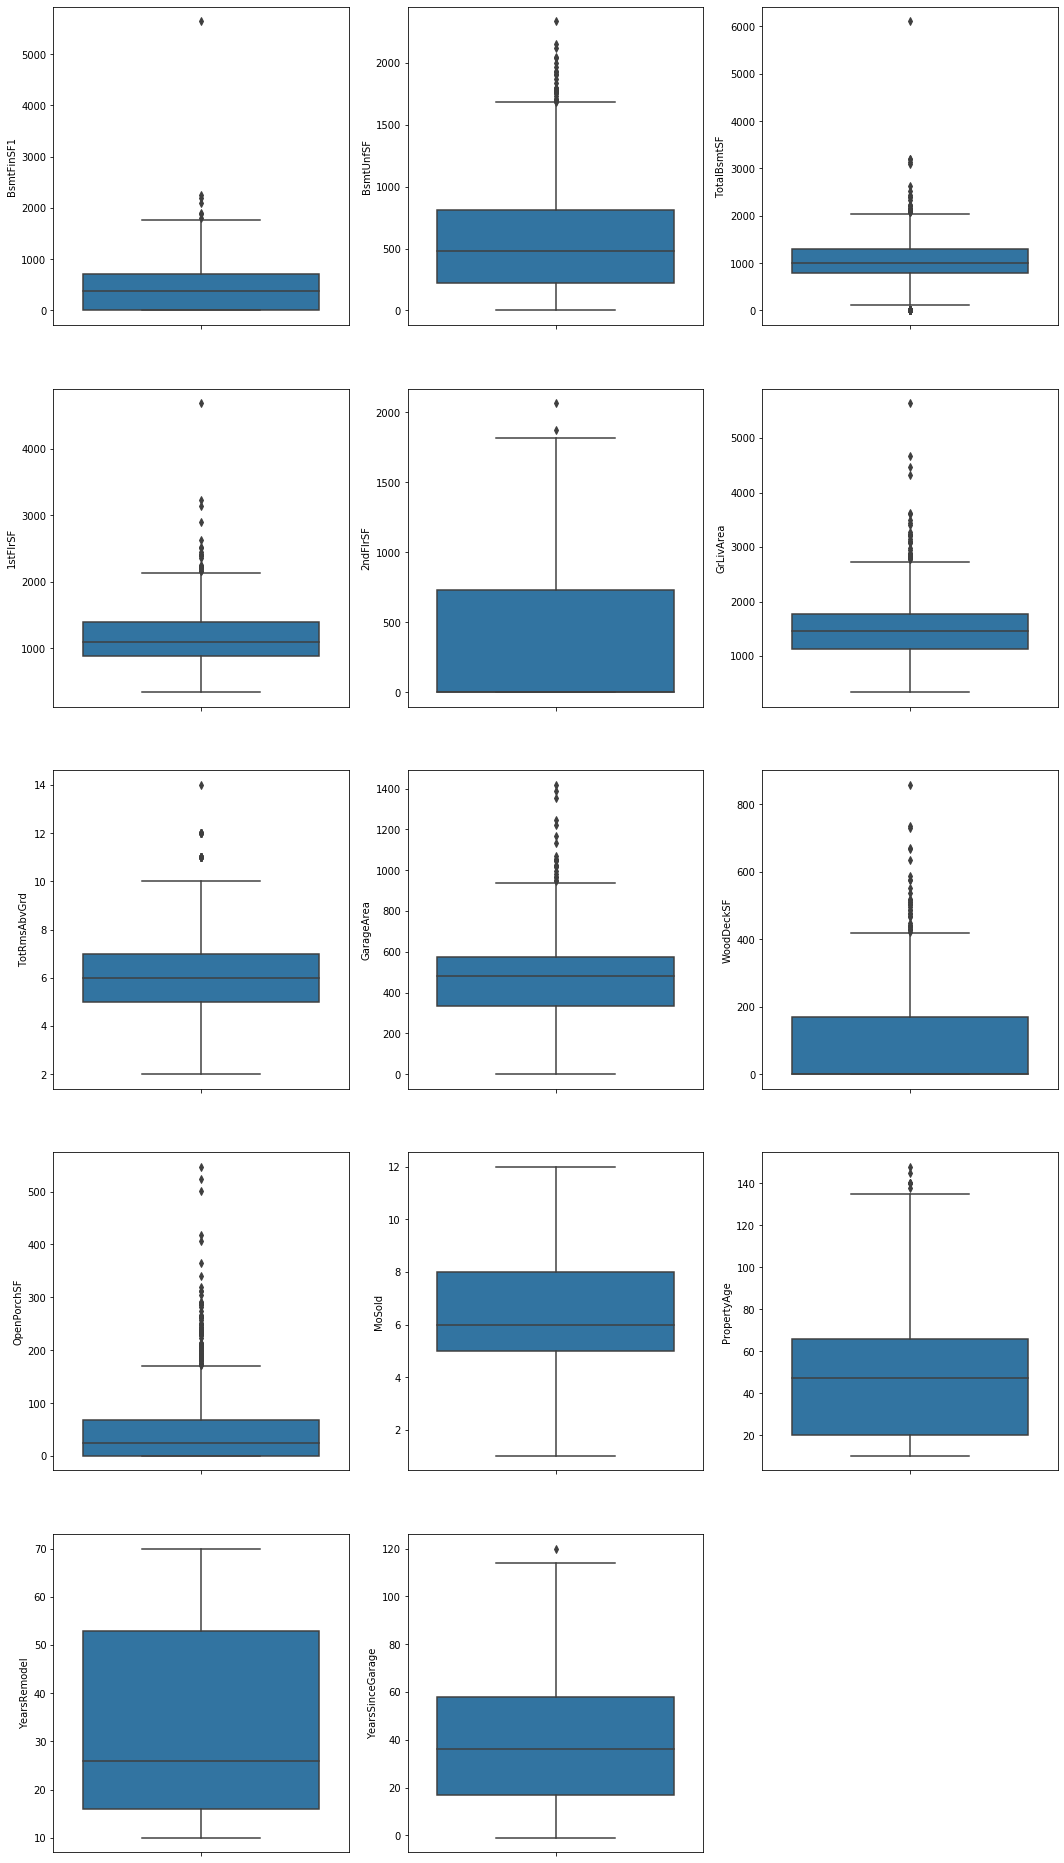

In [92]:
plt.figure(figsize=(18,48))
i=1
for col in columnsForOutliers:
    print(col)
    plt.subplot(7, 3, i)
    sns.boxplot(x=col, data=pricingInfo, orient='v')
    i=i+1

#### Observation 
Following columns need outlier treatment
- TotalBsmtSF
- 1stFlrSF
- GrLivArea
- WoodDeckSF
- OpenPorchSF

In [93]:
pricingInfo.TotalBsmtSF.describe(percentiles=[.1,.25,.3, .5,.75, .8,.9,.95,.97, .98 ,1])

count    1459.000000
mean     1057.891021
std       438.500975
min         0.000000
10%       637.000000
25%       796.000000
30%       840.000000
50%       992.000000
75%      1298.500000
80%      1391.400000
90%      1602.400000
95%      1753.000000
97%      1905.520000
98%      2001.680000
100%     6110.000000
max      6110.000000
Name: TotalBsmtSF, dtype: float64

In [94]:
pricingInfo.shape

(1459, 49)

In [95]:
pricingInfo = pricingInfo.loc[pricingInfo.TotalBsmtSF<6000]
pricingInfo.shape

(1458, 49)

In [96]:
pricingInfo['1stFlrSF'].describe(percentiles=[.1,.25,.3, .5,.75, .8,.9,.95,.97, .98 ,1])

count    1458.000000
mean     1160.486283
std       375.481877
min       334.000000
10%       757.000000
25%       882.000000
30%       916.000000
50%      1087.000000
75%      1391.000000
80%      1482.000000
90%      1680.000000
95%      1828.450000
97%      1977.160000
98%      2069.000000
100%     3228.000000
max      3228.000000
Name: 1stFlrSF, dtype: float64

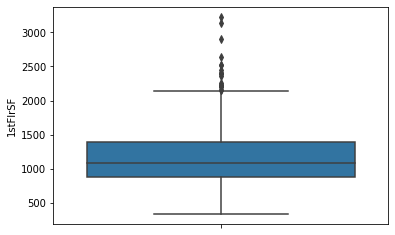

In [97]:
#1stFlrSF
sns.boxplot(x='1stFlrSF', data=pricingInfo, orient='v')

#### Observation
This column does not have outliers now

In [98]:
#GrLivArea
pricingInfo = pricingInfo.loc[pricingInfo.GrLivArea<4000]
pricingInfo.shape

(1455, 49)

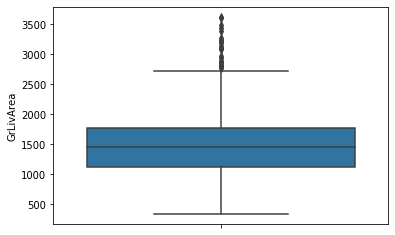

In [99]:
sns.boxplot(x='GrLivArea', data=pricingInfo, orient='v')

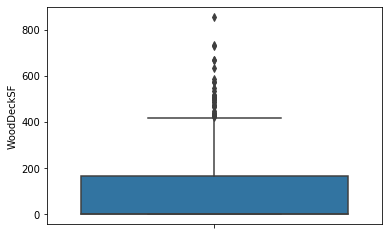

In [100]:
#WoodDeckSF
sns.boxplot(x='WoodDeckSF', data=pricingInfo, orient='v')

In [101]:
#GrLivArea
pricingInfo = pricingInfo.loc[pricingInfo.WoodDeckSF<600]
pricingInfo.shape

(1449, 49)

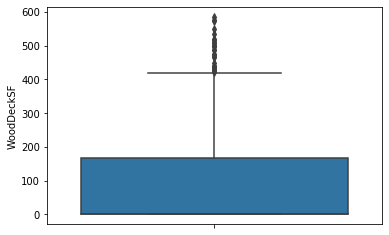

In [102]:
#WoodDeckSF
sns.boxplot(x='WoodDeckSF', data=pricingInfo, orient='v')

### Observation
No more outliers present

In [103]:
# % age of non zero values.
len(pricingInfo.loc[pricingInfo.WoodDeckSF>0].index)/len(pricingInfo.index)

0.4748102139406487

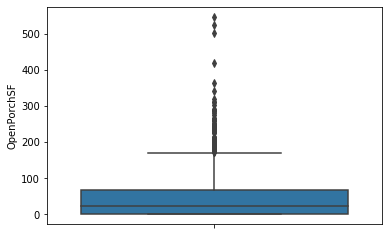

In [104]:
# OpenPorchSF
sns.boxplot(x='OpenPorchSF', data=pricingInfo, orient='v')

In [105]:
pricingInfo['OpenPorchSF'].describe(percentiles=[.1,.25,.3, .5,.75, .8,.9,.95,.97, .98 ,1])

count    1449.000000
mean       46.241546
std        65.459043
min         0.000000
10%         0.000000
25%         0.000000
30%         0.000000
50%        24.000000
75%        68.000000
80%        82.400000
90%       130.000000
95%       173.200000
97%       211.000000
98%       240.000000
100%      547.000000
max       547.000000
Name: OpenPorchSF, dtype: float64

In [106]:
pricingInfo.shape

(1449, 49)

In [107]:
#OpenPorchSF
pricingInfo = pricingInfo.loc[pricingInfo.OpenPorchSF<250]
pricingInfo.shape

(1425, 49)

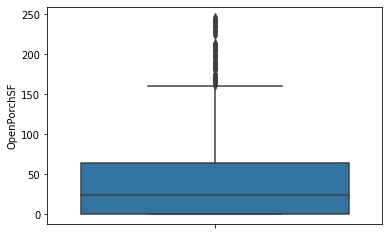

In [108]:
# OpenPorchSF
sns.boxplot(x='OpenPorchSF', data=pricingInfo, orient='v')

In [109]:
pricingInfo.shape

(1425, 49)

### Create dummy variables

In [110]:
catColumns = pricingInfo.select_dtypes('object')
catColumns

,MSZoning,LotShape,LotConfig,Neighborhood,HouseStyle,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,ExterQual,Foundation,BsmtQual,BsmtExposure,BsmtFinType1,HeatingQC,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenQual,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,YearsSinceLastSold
0,RL,Reg,Inside,CollgCr,2Story,Gable,VinylSd,VinylSd,BrkFace,Gd,PConc,Gd,No,GLQ,Ex,1,2,1,3,Gd,0,NoFirePlace,Attchd,RFn,2,12
1,RL,Reg,FR2,Veenker,1Story,Gable,MetalSd,MetalSd,None,TA,CBlock,Gd,Gd,ALQ,Ex,0,2,0,3,TA,1,TA,Attchd,RFn,2,13
2,RL,IR1,Inside,CollgCr,2Story,Gable,VinylSd,VinylSd,BrkFace,Gd,PConc,Gd,Mn,GLQ,Ex,1,2,1,3,Gd,1,TA,Attchd,RFn,2,12
3,RL,IR1,Corner,Crawfor,2Story,Gable,Wd Sdng,Wd Shng,None,TA,BrkTil,TA,No,ALQ,Gd,1,1,0,3,Gd,1,Gd,Detchd,Unf,3,14
4,RL,IR1,FR2,NoRidge,2Story,Gable,VinylSd,VinylSd,BrkFace,Gd,PConc,Gd,Av,GLQ,Ex,1,2,1,4,Gd,1,TA,Attchd,RFn,3,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,FV,Reg,Inside,Somerst,1Story,Gable,VinylSd,VinylSd,None,Gd,PConc,Gd,No,GLQ,Ex,1,2,0,2,Gd,0,NoFirePlace,Attchd,RFn,2,11
1455,RL,Reg,Inside,Gilbert,2Story,Gable,VinylSd,VinylSd,None,TA,PConc,Gd,No,Unf,Ex,0,2,1,3,TA,1,TA,Attchd,RFn,2,13
1456,RL,Reg,Inside,NWAmes,1Story,Gable,Plywood,Plywood,Stone,TA,CBlock,Gd,No,ALQ,TA,1,2,0,3,TA,2,TA,Attchd,Unf,2,10
1457,RL,Reg,Inside,Crawfor,2Story,Gable,CemntBd,CmentBd,None,Ex,Stone,TA,No,GLQ,Ex,0,2,0,4,Gd,2,Gd,Attchd,RFn,1,10


In [111]:
dummyDf = pd.get_dummies(catColumns, drop_first=True, prefix= catColumns.columns)
dummyDf

,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR2,LotShape_IR3,LotShape_Reg,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_NoBasement,BsmtQual_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_NoBasement,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_NoBasement,BsmtFinType1_Rec,BsmtFinType1_Unf,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,BsmtFullBath_1,BsmtFullBath_2,BsmtFullBath_3,FullBath_1,FullBath_2,FullBath_3,HalfBath_1,HalfBath_2,BedroomAbvGr_3,BedroomAbvGr_4,BedroomAbvGr_other,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Fireplaces_1,Fireplaces_2,Fireplaces_3,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_NoFirePlace,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NoGarage,GarageFinish_NoGarage,GarageFinish_RFn,GarageFinish_Unf,GarageCars_1,GarageCars_2,GarageCars_3,GarageCars_4,YearsSinceLastSold_11,YearsSinceLastSold_12,YearsSinceLastSold_13,YearsSinceLastSold_14
0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0
1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0
2,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0
3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1
4,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...

In [112]:
pricingInfo2 = pd.concat([pricingInfo, dummyDf], join='inner', axis=1)
pricingInfo2

,MSSubClass,MSZoning,LotFrontage,LotArea,LotShape,LotConfig,Neighborhood,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,Foundation,BsmtQual,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,HeatingQC,1stFlrSF,2ndFlrSF,GrLivArea,BsmtFullBath,FullBath,HalfBath,BedroomAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,FireplaceQu,GarageType,GarageFinish,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,MoSold,SalePrice,PropertyAge,YearsRemodel,YearsSinceLastSold,YearsSinceGarage,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR2,LotShape_IR3,LotShape_Reg,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_NoBasement,BsmtQual_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_NoBasement,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_NoBasement,BsmtFinType1_Rec,BsmtFinType1_Unf,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,BsmtFullBath_1,BsmtFullBath_2,BsmtFullBath_3,FullBath_1,FullBath_2,FullBath_3,HalfBath_1,HalfBath_2,BedroomAbvGr_3,BedroomAbvGr_4,BedroomAbvGr_other,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Fireplaces_1,Fireplaces_2,Fireplaces_3,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_NoFirePlace,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NoGarage,GarageFinish_NoGarage,GarageFinish_RFn,GarageFinish_Unf,GarageCars_1,GarageCars_2,GarageCars_3,GarageCars_4,YearsSinceLastSold_11,YearsSinceLastSold_12,YearsSinceLastSold_13,YearsSinceLastSold_14
0,60,RL,65.0,8450,Reg,Inside,CollgCr,2Story,7,5,2003,2003,Gable,VinylSd,VinylSd,BrkFace,196.0,Gd,PConc,Gd,No,GLQ,706,150,856,Ex,856,854,1710,1,2,1,3,Gd,8,0,NoFirePlace,Attchd,RFn,2,548,0,61,2,12.247694,17,17,12,17,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0
1,20,RL,80.0,9600,Reg,FR2,Veenker,1Story,6,8,1976,1976,Gable,MetalSd,MetalSd,None,0.0,TA,CBlock,Gd,Gd,ALQ,978,284,1262,Ex,1262,0,1262,0,2,0,3,TA,6,1,TA,Attchd,RFn,2,460,298,0,5,12.109011,44,44,13,44,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,

In [113]:
#drop original variable
pricingInfo2.drop(catColumns, axis=1, inplace=True)

In [114]:
scaledColumns = pricingInfo2.select_dtypes(include=['int64', 'float64'])
scaledColumns.drop('SalePrice', axis=1, inplace=True) # we are not scaling the target variable. 

In [115]:
cols = scaledColumns.columns
scaledColumns = pd.DataFrame(scale(scaledColumns))
scaledColumns.columns = cols
scaledColumns

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,TotRmsAbvGrd,GarageArea,WoodDeckSF,OpenPorchSF,MoSold,PropertyAge,YearsRemodel,YearsSinceGarage
0,0.075923,-0.226634,-0.319471,0.676720,-0.517700,1.053194,0.878476,0.579520,0.641692,-0.945948,-0.462951,-0.806187,1.202035,0.432803,0.954834,0.370996,-0.774170,0.358455,-1.603568,-1.053194,-0.878476,-0.855960
1,-0.871040,0.491362,-0.041675,-0.059407,2.184581,0.153832,-0.425814,-0.601862,1.280094,-0.643332,0.522749,0.295322,-0.793861,-0.483577,-0.303851,-0.046966,1.745172,-0.768563,-0.490341,-0.153832,0.425814,0.187811
2,0.075923,-0.083035,0.356901,0.676720,-0.517700,0.986575,0.830169,0.374586,0.125337,-0.304584,-0.307570,-0.632550,1.230080,0.588260,-0.303851,0.655969,-0.774170,0.007416,0.993962,-0.986575,-0.830169,-0.778643
3,0.312664,-0.465965,-0.053753,0.676720,-0.517700,-1.878059,-0.715656,-0.601862,-0.508372,-0.065201,-0.705735,-0.521314,0.972997,0.447121,0.325492,0.817454,-0.774170,-0.121914,-1.603568,1.878059,0.715656,-0.662669
4,0.075923,0.682827,1.084001,1.412847,-0.517700,0.953265,0.733555,1.507749,0.521991,-0.178118,0.238693,-0.022108,1.667121,1.431002,1.584177,1.738868,0.849030,0.783396,2.107189,-0.953265,-0.733555,-0.739985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1420,-0.871040,-0.370233,-0.548954,0.676720,-0.517700,1.086504,0.975090,-0.601862,-0.053040,0.546804,0.423208,0.184086,-0.793861,-0.567442,-0.303851,-0.331939,-0.774170,1.319191,1.365038,-1.086504,-0.975090,-0.894618
1421,0.075923,-0.370233,-0.448223,-0.059407,-0.517700,0.919956,0.733555,-0.601862,-1.015338,0.867486,-0.227452,-0.543019,0.828096,0.303937,0.325492,-0.046966,-0.774170,-0.029535,0.622886,-0.919956,-0.733555,-0.701327
1422,-0.871040,0.730693,0.821907,-0.059407,0.383060,0.220452,0.153871,0.115406,0.838845,0.045456,1.202543,2.495627,-0.793861,1.175316,0.325492,0.143017,2.176334,-0.768563,-1.603568,-0.220452,-0.153871,0.110495
1423,0.312664,-0.178767,-0.176467,0.676720,3.085341,-1.012007,1.023397,-0.601862,-0.369895,0.695854,0.255688,0.094554,1.898495,1.721462,1.584177,-1.034874,-0.774170,0.339979,-0.490341,1.012007,-1.023397,1.540847


In [116]:
#drop unscaled columns
pricingInfo2.drop(scaledColumns.columns, axis=1, inplace=True)

#concat dataframes to include scaled columns
pricingInfo2 = pd.concat([scaledColumns, pricingInfo2], join='inner', axis=1)
pricingInfo2

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,TotRmsAbvGrd,GarageArea,WoodDeckSF,OpenPorchSF,MoSold,PropertyAge,YearsRemodel,YearsSinceGarage,SalePrice,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR2,LotShape_IR3,LotShape_Reg,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone,ExterQual_Fa,ExterQual_Gd,ExterQual_TA,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_NoBasement,BsmtQual_TA,BsmtExposure_Gd,BsmtExposure_Mn,BsmtExposure_No,BsmtExposure_NoBasement,BsmtFinType1_BLQ,BsmtFinType1_GLQ,BsmtFinType1_LwQ,BsmtFinType1_NoBasement,BsmtFinType1_Rec,BsmtFinType1_Unf,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,BsmtFullBath_1,BsmtFullBath_2,BsmtFullBath_3,FullBath_1,FullBath_2,FullBath_3,HalfBath_1,HalfBath_2,BedroomAbvGr_3,BedroomAbvGr_4,BedroomAbvGr_other,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Fireplaces_1,Fireplaces_2,Fireplaces_3,FireplaceQu_Fa,FireplaceQu_Gd,FireplaceQu_NoFirePlace,FireplaceQu_Po,FireplaceQu_TA,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NoGarage,GarageFinish_NoGarage,GarageFinish_RFn,GarageFinish_Unf,GarageCars_1,GarageCars_2,GarageCars_3,GarageCars_4,YearsSinceLastSold_11,YearsSinceLastSold_12,YearsSinceLastSold_13,YearsSinceLastSold_14
0,0.075923,-0.226634,-0.319471,0.676720,-0.517700,1.053194,0.878476,0.579520,0.641692,-0.945948,-0.462951,-0.806187,1.202035,0.432803,0.954834,0.370996,-0.774170,0.358455,-1.603568,-1.053194,-0.878476,-0.855960,12.247694,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0
1,-0.871040,0.491362,-0.041675,-0.059407,2.184581,0.153832,-0.425814,-0.601862,1.280094,-0.643332,0.522749,0.295322,-0.793861,-0.483577,-0.303851,-0.046966,1.745172,-0.768563,-0.490341,-0.153832,0.425814,0.187811,12.109011,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0
2,0.075923,-0.083035,0.356901,0.676720,-0.517700,0.986575,0.830169,0.374586,0.125337,-0.304584,-0.307570,-0.632550,1.230080,0.588260,-0.303851,0.655969,-0.774170,0.007416,0.993962,-0.986575,-0.830169,-0.778643,12.

In [117]:
y= pricingInfo2['SalePrice']
X = pricingInfo2.drop('SalePrice', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y,train_size=0.7,test_size = 0.3, random_state=100)

### Ridge Regression

In [118]:
# Running RFE with the output number of the variable equal to 10
lm =  Ridge()
lm.fit(X_train, y_train)

rfe = RFE(lm, 50)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [119]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('MSSubClass', False, 88),
 ('LotFrontage', False, 86),
 ('LotArea', False, 84),
 ('OverallQual', False, 99),
 ('OverallCond', False, 107),
 ('YearBuilt', False, 104),
 ('YearRemodAdd', False, 110),
 ('MasVnrArea', False, 105),
 ('BsmtFinSF1', False, 72),
 ('BsmtUnfSF', False, 73),
 ('TotalBsmtSF', False, 62),
 ('1stFlrSF', False, 24),
 ('2ndFlrSF', False, 26),
 ('GrLivArea', False, 25),
 ('TotRmsAbvGrd', False, 74),
 ('GarageArea', False, 96),
 ('WoodDeckSF', False, 112),
 ('OpenPorchSF', False, 81),
 ('MoSold', False, 103),
 ('PropertyAge', False, 97),
 ('YearsRemodel', False, 106),
 ('YearsSinceGarage', False, 92),
 ('MSZoning_FV', True, 1),
 ('MSZoning_RH', True, 1),
 ('MSZoning_RL', True, 1),
 ('MSZoning_RM', True, 1),
 ('LotShape_IR2', False, 14),
 ('LotShape_IR3', True, 1),
 ('LotShape_Reg', False, 77),
 ('LotConfig_CulDSac', False, 28),
 ('LotConfig_FR2', True, 1),
 ('LotConfig_FR3', False, 37),
 ('LotConfig_Inside', False, 67),
 ('Neighborhood_Blueste', True, 1),
 ('Neighborh

In [120]:
col = X_train.columns[rfe.support_]
col

Index(['MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM',
       'LotShape_IR3', 'LotConfig_FR2', 'Neighborhood_Blueste',
       'Neighborhood_BrDale', 'Neighborhood_ClearCr', 'Neighborhood_Crawfor',
       'Neighborhood_MeadowV', 'Neighborhood_NPkVill', 'Neighborhood_NoRidge',
       'Neighborhood_NridgHt', 'Neighborhood_Somerst', 'Neighborhood_StoneBr',
       'Exterior1st_BrkFace', 'Exterior1st_CemntBd', 'Exterior1st_Stone',
       'Exterior1st_Stucco', 'Exterior1st_WdShing', 'Exterior2nd_Stone',
       'Exterior2nd_Stucco', 'ExterQual_Fa', 'BsmtQual_Fa', 'BsmtQual_Gd',
       'BsmtQual_NoBasement', 'BsmtQual_TA', 'BsmtExposure_Gd',
       'BsmtExposure_NoBasement', 'BsmtFinType1_NoBasement', 'HeatingQC_Fa',
       'FullBath_2', 'FullBath_3', 'HalfBath_1', 'KitchenQual_Fa',
       'KitchenQual_Gd', 'KitchenQual_TA', 'Fireplaces_2', 'Fireplaces_3',
       'FireplaceQu_NoFirePlace', 'GarageType_Attchd', 'GarageType_Basment',
       'GarageType_BuiltIn', 'GarageType_CarPort', 

In [121]:
# list of alphas to tune
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}

X_train_rfe = X_train[col]
ridge = Ridge()

# cross validation
folds = 5
model_cv = GridSearchCV(estimator = ridge, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            
model_cv.fit(X_train_rfe, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    0.6s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=None, normalize=False, random_state=None,
                             solver='auto', tol=0.001),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_absolute_error', verbose=1)

In [122]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results = cv_results[cv_results['param_alpha']<=200]
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.002992,0.000892,0.000997,4.623108e-07,0.0001,{'alpha': 0.0001},-0.111802,-0.120639,-0.130603,-0.122085,-0.120962,-0.121218,0.005965,15,-0.111698,-0.109487,-0.107015,-0.108560,-0.111105,-0.109573,0.001699
1,0.003192,0.000399,0.000997,9.818678e-07,0.001,{'alpha': 0.001},-0.111794,-0.120642,-0.130584,-0.122086,-0.120955,-0.121212,0.005961,14,-0.111697,-0.109488,-0.107016,-0.108561,-0.111104,-0.109573,0.001699
2,0.002793,0.000747,0.000997,9.702201e-07,0.01,{'alpha': 0.01},-0.111713,-0.120678,-0.130393,-0.122092,-0.120879,-0.121151,0.005927,13,-0.111691,-0.109494,-0.107022,-0.108565,-0.111097,-0.109574,0.001693
3,0.001796,0.000399,0.000797,3.987107e-04,0.05,{'alpha': 0.05},-0.111377,-0.120827,-0.129638,-0.122122,-0.120554,-0.120904,0.005808,11,-0.111679,-0.109525,-0.107043,-0.108585,-0.111075,-0.109581,0.001677
4,0.003590,0.000797,0.001596,4.885776e-04,0.1,{'alpha': 0.1},-0.111270,-0.120995,-0.129097,-0.122155,-0.120174,-0.120738,0.005690,10,-0.111688,-0.109590,-0.107121,-0.108608,-0.111068,-0.109615,0.001652


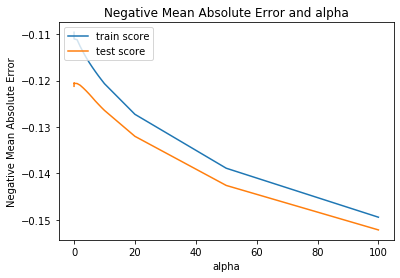

In [123]:
# plotting mean test and train scoes with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('int32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')
plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [124]:
alpha = 10 
ridge = Ridge(alpha=alpha)

ridge.fit(X_train_rfe, y_train)
ridge.coef_

array([ 0.06032999,  0.05050085,  0.12355451, -0.00176303,  0.05567402,
       -0.05365862, -0.01107408, -0.06241001,  0.05589701,  0.15527708,
       -0.17456243, -0.08913507,  0.12940006,  0.13298597,  0.08455034,
        0.11183471,  0.07065983,  0.04566126,  0.0427076 ,  0.05019782,
       -0.07610092, -0.03217342, -0.01687458, -0.11713588, -0.15905443,
       -0.08192345, -0.10582581, -0.13545116,  0.14479436, -0.1065046 ,
       -0.10582581, -0.12724482,  0.13034078,  0.23822852,  0.08466639,
       -0.19820372, -0.06839065, -0.17736699,  0.09652101,  0.04118154,
       -0.08925577,  0.11616956,  0.02146483,  0.08974669, -0.05685843,
        0.02654366, -0.15053262, -0.08936319,  0.17551091,  0.04350261])

## Lasso

In [125]:
# Running RFE with the output number of the variable equal to 10
lm =  Lasso()
lm.fit(X_train, y_train)

rfe = RFE(lm, 50)             # running RFE
rfe = rfe.fit(X_train, y_train)

In [126]:
list(zip(X_train.columns,rfe.support_,rfe.ranking_))

[('MSSubClass', False, 117),
 ('LotFrontage', False, 116),
 ('LotArea', False, 115),
 ('OverallQual', False, 114),
 ('OverallCond', False, 113),
 ('YearBuilt', False, 112),
 ('YearRemodAdd', False, 111),
 ('MasVnrArea', False, 110),
 ('BsmtFinSF1', False, 109),
 ('BsmtUnfSF', False, 108),
 ('TotalBsmtSF', False, 107),
 ('1stFlrSF', False, 106),
 ('2ndFlrSF', False, 105),
 ('GrLivArea', False, 104),
 ('TotRmsAbvGrd', False, 103),
 ('GarageArea', False, 102),
 ('WoodDeckSF', False, 101),
 ('OpenPorchSF', False, 100),
 ('MoSold', False, 99),
 ('PropertyAge', False, 98),
 ('YearsRemodel', False, 97),
 ('YearsSinceGarage', False, 96),
 ('MSZoning_FV', False, 95),
 ('MSZoning_RH', False, 94),
 ('MSZoning_RL', False, 93),
 ('MSZoning_RM', False, 92),
 ('LotShape_IR2', False, 91),
 ('LotShape_IR3', False, 90),
 ('LotShape_Reg', False, 89),
 ('LotConfig_CulDSac', False, 88),
 ('LotConfig_FR2', False, 87),
 ('LotConfig_FR3', False, 86),
 ('LotConfig_Inside', False, 85),
 ('Neighborhood_Blueste',

In [127]:
col = X_train.columns[rfe.support_]
col

Index(['BsmtExposure_NoBasement', 'BsmtFinType1_BLQ', 'BsmtFinType1_GLQ',
       'BsmtFinType1_LwQ', 'BsmtFinType1_NoBasement', 'BsmtFinType1_Rec',
       'BsmtFinType1_Unf', 'HeatingQC_Fa', 'HeatingQC_Gd', 'HeatingQC_Po',
       'HeatingQC_TA', 'BsmtFullBath_1', 'BsmtFullBath_2', 'BsmtFullBath_3',
       'FullBath_1', 'FullBath_2', 'FullBath_3', 'HalfBath_1', 'HalfBath_2',
       'BedroomAbvGr_3', 'BedroomAbvGr_4', 'BedroomAbvGr_other',
       'KitchenQual_Fa', 'KitchenQual_Gd', 'KitchenQual_TA', 'Fireplaces_1',
       'Fireplaces_2', 'Fireplaces_3', 'FireplaceQu_Fa', 'FireplaceQu_Gd',
       'FireplaceQu_NoFirePlace', 'FireplaceQu_Po', 'FireplaceQu_TA',
       'GarageType_Attchd', 'GarageType_Basment', 'GarageType_BuiltIn',
       'GarageType_CarPort', 'GarageType_Detchd', 'GarageType_NoGarage',
       'GarageFinish_NoGarage', 'GarageFinish_RFn', 'GarageFinish_Unf',
       'GarageCars_1', 'GarageCars_2', 'GarageCars_3', 'GarageCars_4',
       'YearsSinceLastSold_11', 'YearsSinceLastS

In [128]:
X_train.columns[~rfe.support_]

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF',
       ...
       'Foundation_Slab', 'Foundation_Stone', 'Foundation_Wood', 'BsmtQual_Fa',
       'BsmtQual_Gd', 'BsmtQual_NoBasement', 'BsmtQual_TA', 'BsmtExposure_Gd',
       'BsmtExposure_Mn', 'BsmtExposure_No'],
      dtype='object', length=116)

In [129]:
lasso = Lasso()
X_train_rfe = X_train[col]
params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000 ]}
folds=5
# cross validation
model_cv = GridSearchCV(estimator = lasso, 
                        param_grid = params, 
                        scoring= 'neg_mean_absolute_error', 
                        cv = folds, 
                        return_train_score=True,
                        verbose = 1)            

model_cv.fit(X_train, y_train) 

Fitting 5 folds for each of 28 candidates, totalling 140 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 140 out of 140 | elapsed:    1.2s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=1000, normalize=False, positive=False,
                             precompute=False, random_state=None,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='neg_mean_absolute_error', verbose=1)

In [130]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.065028,0.006949,0.001594,7.966970e-04,0.0001,{'alpha': 0.0001},-0.113099,-0.122643,-0.129851,-0.117514,-0.124898,-0.121601,0.005814,2,-0.097288,-0.094851,-0.093007,-0.095902,-0.096035,-0.095417,0.001432
1,0.013165,0.002918,0.001398,4.909610e-04,0.001,{'alpha': 0.001},-0.111818,-0.126168,-0.128764,-0.121183,-0.117891,-0.121165,0.006014,1,-0.109046,-0.105639,-0.102918,-0.106346,-0.108021,-0.106394,0.002113
2,0.005187,0.000747,0.001396,4.877797e-04,0.01,{'alpha': 0.01},-0.131311,-0.158158,-0.163308,-0.152747,-0.145363,-0.150178,0.011152,3,-0.149173,-0.142680,-0.143634,-0.142603,-0.144913,-0.144601,0.002434
3,0.003790,0.000399,0.000997,5.091228e-07,0.05,{'alpha': 0.05},-0.207147,-0.215140,-0.218918,-0.210139,-0.192526,-0.208774,0.009077,4,-0.208278,-0.204158,-0.207461,-0.208181,-0.208754,-0.207366,0.001657
4,0.003792,0.000398,0.000995,2.694868e-06,0.1,{'alpha': 0.1},-0.290755,-0.287666,-0.299526,-0.294318,-0.258194,-0.286092,0.014496,5,-0.285182,-0.284595,-0.284773,-0.285276,-0.287049,-0.285375,0.000874


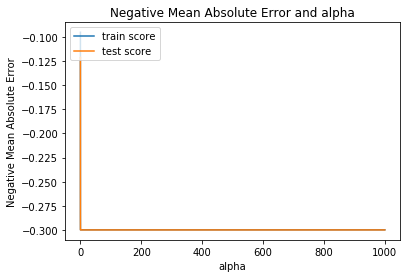

In [131]:
# plotting mean test and train scoes with alpha 
cv_results['param_alpha'] = cv_results['param_alpha'].astype('float32')

# plotting
plt.plot(cv_results['param_alpha'], cv_results['mean_train_score'])
plt.plot(cv_results['param_alpha'], cv_results['mean_test_score'])
plt.xlabel('alpha')
plt.ylabel('Negative Mean Absolute Error')

plt.title("Negative Mean Absolute Error and alpha")
plt.legend(['train score', 'test score'], loc='upper left')
plt.show()

In [132]:
alpha =0

lasso = Lasso(alpha=alpha)
        
lasso.fit(X_train_rfe, y_train) 

Lasso(alpha=0, copy_X=True, fit_intercept=True, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=None, selection='cyclic',
      tol=0.0001, warm_start=False)

In [133]:
lasso.coef_

array([-6.60918432e-02,  2.70406113e-03,  3.15705984e-02, -1.70883441e-02,
       -1.27033816e-01,  6.47041730e-03, -5.74221774e-02, -1.73269859e-01,
       -4.72873405e-02,  0.00000000e+00, -5.40260443e-02,  5.53035587e-02,
        3.07291098e-01,  2.04663682e-01,  2.22510190e-01,  3.73740285e-01,
        6.33559335e-01,  7.64661470e-02,  1.17701414e-01,  4.09256553e-02,
        8.61832604e-02, -6.19797317e-02, -3.56338984e-01, -1.81511905e-01,
       -2.85841288e-01,  1.17608643e-01,  2.24128072e-01,  2.73255803e-01,
       -1.26252606e-01, -4.90119297e-02, -6.14124117e-02, -2.03905927e-01,
       -9.04523761e-02,  3.79388215e-01,  3.26604358e-01,  3.22816712e-01,
        7.30371014e-02,  3.08311111e-01, -4.62367902e-02,  1.17798147e-15,
       -1.27162809e-02, -6.66173604e-02, -1.73622380e-01, -6.70334268e-02,
        1.50898477e-01,  3.36724218e-02, -1.49903306e-02,  7.28825311e-03,
        2.97423831e-02,  8.02183320e-03])